<a href="https://colab.research.google.com/github/LeslyJaramillo/INTELIGENCIA-ARTIFICIAL/blob/main/GradCAM%2B%2B_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# IMPORTAR LIBRERIAS



In [ ]:
!pip install tf-keras-vis tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.datasets import fashion_mnist
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib import cm

# CARGAR DATASET


En esta seccion se prepara el conjunto de datos Fashion MNIST para ser usado en un modelo CNN, normalizando los datos y ajustando la forma de las imágenes para que incluyan un canal de profundidad adicional


In [ ]:

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#Redimensionar los datos para ser compatibles con un modelo CNN
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# AUTOENCODER

Een esta sección del código, se crea un autoencoder para aprender una representación comprimida de imágenes, y luego utiliza la parte codificadora del autoencoder como entrada para un modelo CNN que se entrena para clasificar imágenes en el conjunto de datos Fashion MNIST

In [ ]:
latent_dim = 64
inputs = Input(shape=(28, 28, 1))
encoded = layers.Flatten()(inputs)
encoded = layers.Dense(latent_dim, activation='relu')(encoded)

decoded = layers.Dense(28*28, activation='sigmoid')(encoded)
decoded = layers.Reshape((28, 28, 1))(decoded)

autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train, x_train, epochs=5, validation_data=(x_test, x_test))

encoder = models.Model(inputs, encoded)   #Extraer la parte del codificador del autoencoder

# Definir el modelo CNN utilizando la salida del codificador
encoded_input = encoder(inputs)
x = layers.Dense(128, activation='relu')(encoded_input)
x = layers.Reshape((16, 8, 1))(x)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

# Crear el modelo final
model = models.Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo de clasificación
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Evaluar el modelo
model.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0402 - val_loss: 0.0131
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0122 - val_loss: 0.0106
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.7509 - loss: 0.7056 - val_accuracy: 0.8467 - val_loss: 0.4262
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8614 - loss: 0.3775 - val_accuracy: 0.8497 - val_loss: 0.4002
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.8747 - loss: 0.3388 - val_accuracy: 0.8670 - val_loss: 0.3620
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.8840 - loss: 0.3153 - val_accuracy: 0.8564 - val_loss: 0.3817
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━

[0.33606868982315063, 0.8748999834060669]

# GradCAM++

Esta diseñada para proporcionar una visualización más precisa de las regiones importantes en la imagen que contribuyen a la decisión del modelo. Estas técnicas ayudan a interpretar y entender las decisiones de los modelos de redes neuronales profundas, particularmente en aplicaciones de visión por computadora.Su propósito es identificar y visualizar qué partes de una imagen influyen más en la decisión de clasificación de una red neuronal y su funcionamiento se basa en los gradientes de la clase objetivo con respecto a los mapas de activación de la última capa convolucional para generar un mapa de activación que destaca las regiones importantes en la imagen.

En esta sección se prepara el entorno para generar mapas de activación de Grad-CAM++ que visualizan las áreas relevantes de las imágenes en función de las decisiones del modelo de red neuronal.

In [ ]:
# Configuración para Grad-CAM++
replace2linear = ReplaceToLinear()

# Crear el objeto GradCAM++
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)


# RECONTRUCCIÓN


En esta sección se calcula la pérdida de reconstrucción para una imagen dada. La función toma una imagen como entrada, la pasa a través de un autoencoder para obtener su reconstrucción, y luego calcula la pérdida como el error cuadrático medio entre la imagen original y su reconstrucción. Esta medida de pérdida indica cuán bien el autoencoder ha reconstruido la imagen y se utiliza para evaluar el desempeño del modelo.

In [ ]:
# Función para calcular la pérdida de reconstrucción
def calcular_perdida_reconstruccion(imagen):
    reconstruccion = autoencoder.predict(np.expand_dims(imagen, 0))
    perdida = np.mean((reconstruccion - imagen) ** 2)
    return perdida

# GRAFICOS

En esta sección del código se define una función mostrar_mapas_de_calor que visualiza los mapas de calor de activación para diferentes clases y capas de una red neuronal. Para cada combinación de clase y capa especificada, se selecciona una imagen de prueba de la clase, se calcula su pérdida de reconstrucción, y se genera un mapa de calor utilizando Grad-CAM++. Este mapa de calor se escala según la pérdida de reconstrucción para reflejar la intensidad de las activaciones. Luego, se superpone el mapa de calor sobre la imagen original y se muestra en una cuadrícula de subgráficas, donde cada celda representa una combinación de clase y capa. Además, se añade una barra de color para indicar la escala de intensidades.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-6-0cee9d640ff3>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ajustar para hacer espacio para la barra de color


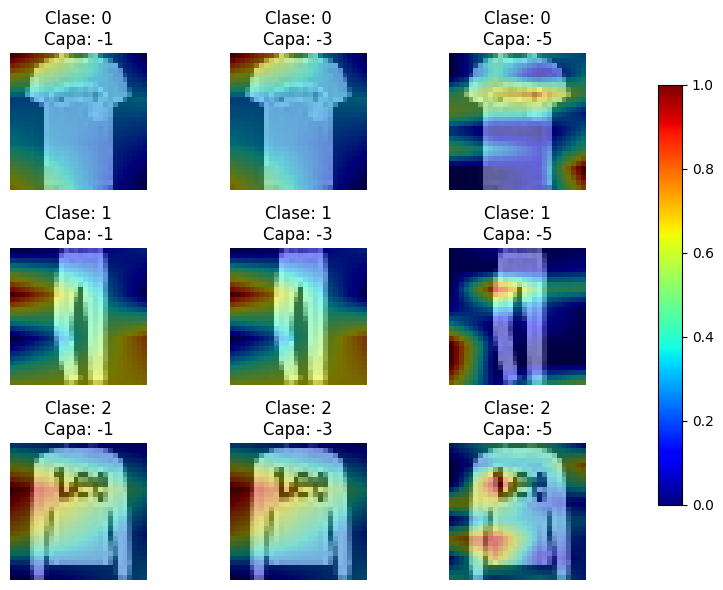

In [ ]:


# Función para mostrar los mapas de calor
def mostrar_mapas_de_calor(clases, capas, figsize=(12, 8)):
    # Preparar los gráficos
    fig, ax = plt.subplots(len(capas), len(clases), figsize=figsize, sharex=True, sharey=True)

    # Gráfico: Eje Y = Capas, Eje X = Clases
    for i, layer_idx in enumerate(capas):
        for j, class_idx in enumerate(clases):
            # Filtrar las imágenes de prueba que pertenecen a la clase actual
            indices = np.where(y_test == class_idx)[0]
            images = x_test[indices][:1]  # Selecciona una imagen de esta clase

            # Calcular la pérdida de reconstrucción para la imagen
            perdida_reconstruccion = calcular_perdida_reconstruccion(images[0])

            # Obtener el score y aplicar GradCAM++ en la capa seleccionada
            score = CategoricalScore([class_idx])
            cam = gradcam(score, images, penultimate_layer=layer_idx)

            # Escalar el mapa de calor según la pérdida de reconstrucción
            intensidad = np.clip(1 - perdida_reconstruccion, 0, 1)  # Mayor intensidad para menor pérdida
            heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255 * intensidad)

            # Mostrar la imagen y el mapa de calor
            ax[j, i].imshow(np.squeeze(images[0]), cmap='gray')
            ax[j, i].imshow(heatmap, cmap='jet', alpha=0.5)
            ax[j, i].set_title(f'Clase: {class_idx}\nCapa: {layer_idx}')
            ax[j, i].axis('off')

    # Añadir una barra de color
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ajustar para hacer espacio para la barra de color
    plt.show()

# Parámetros de ejemplo para visualizar
clases_a_analizar = [0, 1, 2]  # T-Shirt, Trouser, Pullover
capas_a_visualizar = [-1, -3, -5]  # Capas que se van a analizar

# Mostrar los mapas de calor
mostrar_mapas_de_calor(clases_a_analizar, capas_a_visualizar, figsize=(8, 6))
